In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from copy import deepcopy

In [2]:
# basic config
token_limit = 2500

In [4]:
input_file_path = '../data/raw_data/2018_1_small.csv'
output_file_path = '../data/synthetic_data/2018_1_small.csv'
df = pd.read_csv(input_file_path, index_col=0)
df

,outlet,headline,body,political_leaning
56697,Breitbart,"VIDEO: Hero German Shepherd Shot, Beaten Defen...",A two-year-old German Shepherd went above and ...,RIGHT
37940,ABC News,The Note: Trump meets market jumps with volati...,The TAKE with Rick Klein\nInterested in The No...,CENTER
164540,Reuters,UK consumers ramp up borrowing again after win...,LONDON (Reuters) - Britain’s consumers picked ...,CENTER
152418,The New York Times,"Justice Department, Texas, Venezuela: Your Mon...",Good morning.\nHere’s what you need to know:\n...,LEFT
40999,The Guardian,Schools are not the answer to childhood obesit...,Obesity Schools are not the answer to childhoo...,LEFT
...,...,...,...,...
156579,Politico,Trump considering 25 percent tax on car import...,Trump considering 25 percent tax on car import...,UNDEFINED
170679,BBC,Relaxing visa rules for doctors and nurses,Image copyright SCIENCE PHOTO LIBRARY\nA lette...,UNDEFINED
160971,HuffPost,Carl Bernstein Warns Of 'Authoritarianism' As ...,Legendary journalist Carl Bernstein warned Pre...,LEFT
149397,The Wall Street Journal,"U.S. Farms, Factories Can’t Produce Enough to ...",The White House is likely to fall well short o...,UNDEFINED


In [6]:
def count_tokens_in_text(string: str, encoding_name: str) -> int:
    """
    This function calculates the number of tokens in a text string.
    Input: string (text from which the number of tokens need to be counted), encoding_name (encoding scheme to use)
    Output: num_tokens (number of tokens in the input string)
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
# get the number of words in each body, as a new column
df['n_words'] = df['body'].str.split().str.len()
# get the number of tokens in each body, as a new column
df['n_tokens'] = df['body'].apply(lambda x: count_tokens_in_text(x, 'cl100k_base')) # cl100k_base is for gpt3.5 and gpt4
df

,outlet,headline,body,political_leaning,n_words,n_tokens
56697,Breitbart,"VIDEO: Hero German Shepherd Shot, Beaten Defen...",A two-year-old German Shepherd went above and ...,RIGHT,262,343
37940,ABC News,The Note: Trump meets market jumps with volati...,The TAKE with Rick Klein\nInterested in The No...,CENTER,1139,1471
164540,Reuters,UK consumers ramp up borrowing again after win...,LONDON (Reuters) - Britain’s consumers picked ...,CENTER,480,603
152418,The New York Times,"Justice Department, Texas, Venezuela: Your Mon...",Good morning.\nHere’s what you need to know:\n...,LEFT,163,204
40999,The Guardian,Schools are not the answer to childhood obesit...,Obesity Schools are not the answer to childhoo...,LEFT,726,833
...,...,...,...,...,...,...
156579,Politico,Trump considering 25 percent tax on car import...,Trump considering 25 percent tax on car import...,UNDEFINED,695,826
170679,BBC,Relaxing visa rules for doctors and nurses,Image copyright SCIENCE PHOTO LIBRARY\nA lette...,UNDEFINED,720,884
160971,HuffPost,Carl Bernstein Warns Of 'Authoritarianism' As ...,Legendary journalist Carl Bernstein warned Pre...,LEFT,301,385
149397,The Wall Street Journal,"U.S. Farms, Factories Can’t Produce Enough to ...",The White House is likely to fall well short o...,UNDEFINED,91,112


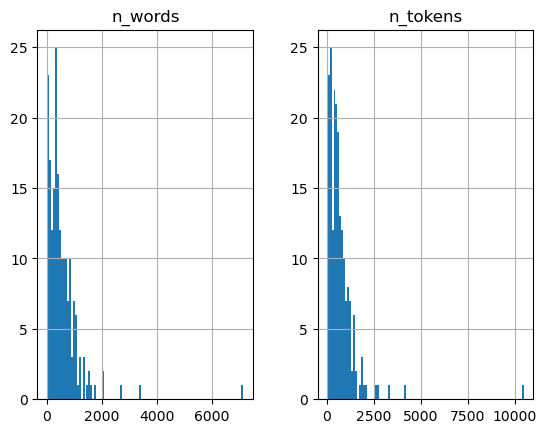

In [8]:
# a histogram of the number of words in each body and the number of tokens in each body
df.hist(column=['n_words', 'n_tokens'], bins=100)
plt.show()

In [9]:
# only keep the rows where the number of tokens is less than the token limit
df = df[df['n_tokens'] < token_limit]
# delete rows where body is empty
df = df[df['body'].notna()]

In [10]:
from config import OPENAI_API_KEY
import openai
import os

In [12]:
openai.api_key = OPENAI_API_KEY
# Base prompt for the AI
messages = [
  {
    "role": "system",
    "content": "Analyze the provided media text and extract the main causal sequences. \
      Present the findings strictly in the format '1. Event A -> Event B -> Event C  2. Event D -> Event E', \
      ensuring that each listed sequence represents a direct, sequential, and acyclic relationship. \
      Use only the terminology from the original text and ensure that the content is respectful and non-offensive."
  },
  {
    "role": "user",
    "content": "Analyze this news excerpt: {media_text}. List the essential causal chains, ensuring that the output strictly adheres to the format specified and focuses solely on the primary narrative."
  }
]


In [13]:
# iterate first 3 rows
for index, row in df.head(3).iterrows():
    # Get the news text from the 'body' column
    news_text = row['body']

    # Prepare the prompt by inserting the news text into the template
    prompt = deepcopy(messages)
    prompt[1]["content"] = prompt[1]["content"].replace("{media_text}", news_text)


    # Make the API request (you might want to handle exceptions and rate limits here)
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=prompt
    )

    # Extract the analysis from the response
    analysis_results = response['choices'][0]['message']['content']

    # Store the analysis results back in your DataFrame
    df.at[index, 'ai_analysis'] = analysis_results

    # Optional: print progress
    print(f"Processed row {index + 1} of {len(df)}")


Processed row 56698 of 195


KeyboardInterrupt: 

In [12]:
# demo for first body
print(df['body'][0])

A two-year-old German Shepherd went above and beyond to protect his owner after he took bullets and blows defending his best friend from home invaders.
The 16-year-old owner, Javier Mercado, hid in his closet with his dog Rex as burglars ransacked his Des Moines, Iowa, home Wednesday, KWCH reported.
“As soon as he heard the window shatter, he ran downstairs full charge,” Mercado told KOMO. “And then I just heard a bunch of barking and struggling, and then one of the guys screaming, ‘The dog! The dog bit me! Get the dog!’”
Rex, sensing there was danger in the house, ran downstairs to confront the burglars—who ruthlessly beat him.
As the burglars continued to pilfer through the house, they approached the room where the teen was hiding. Although Rex had little strength left in him, he pounced on the burglars.
“I think if it wasn’t for him, I probably wouldn’t be standing here today,” Mercado said.
The hero German Shepherd was shot three times trying to take down the burglars.
Once the bur

In [13]:
# ai analysis is separated by \n
ai_analyis_of_first_body = df['ai_analysis'][0].split('\n')
for analysis in ai_analyis_of_first_body:
    print(analysis)

1. Burglars invade Javier Mercado's home -> Rex senses danger and runs downstairs
2. Rex confronts burglars -> Burglars beat Rex
3. Burglars approach the room where Javier Mercado is hiding -> Rex pounces on burglars
4. Rex is shot three times by the burglars -> Burglars hear police sirens and flee
5. Police arrive at the home -> Rex is rushed to a local veterinarian
6. Rex receives medical treatment -> Rex is placed in intensive care 
7. A GoFundMe page is set up -> People donate money to pay for Rex's veterinary bills.


In [14]:
ai_analyis_of_first_body = df['ai_analysis'][1].split('\n')
for analysis in ai_analyis_of_first_body:
    print(analysis)

1. President Donald Trump tests new midterm material -> accuses Democrats of "treason" for not applauding during his State of the Union address
2. Running on a booming stock market makes it harder not to own a slide -> risk in campaigning against Democrats as "un-American"
3. Markets in freefall and presidential attacks showing on split-screen -> political landscape may not be ready for Trump
4. Republicans vote to unseal Democrats' rebuttal memo -> Democratic memo pushes back against idea of FBI abuse of power
5. Devin Nunes becomes a prime target for Democrats -> Andrew Janz hopes to end Nunes' congressional career
6. Andrew Janz raises more money and showcases Nunes' political stunts -> plans to hold Nunes accountable in the November elections.


In [15]:
## save the dataframe to a csv file
df.to_csv(output_file_path)

1. Consumers borrowing increased in April -> Could reassure the Bank of England that the economy is ready for another interest rate hike
2. Survey showed consumers turned more confident in May -> Possibly reflecting an easing of a Brexit-related squeeze on their spending power
3. Figures give Monetary Policy Committee increased confidence -> Q1 slowdown was just a blip
4. Figures chime with strong retail sales in April -> Consumer spending growth is starting to strengthen
5. Rise in consumer confidence in May suggests consumer credit growth will continue to grow strongly
6. Britain's economy nearly ground to a halt in Q1 2018 -> Prompted the BoE to hold off from raising interest rates
7. Sharp fall in consumer borrowing also influenced the BoE's decision to keep rates on hold
8. Consumer credit jumped by 1.832 billion pounds in April, up from increase of 425 million pounds in March
9. Growth rate in consumer lending edged up to 8.8 percent in May from 8.6 percent in March
10. Squeeze o

In [16]:
df.head(3)[['body', 'ai_analysis']]

,body,ai_analysis
0,A two-year-old German Shepherd went above and ...,1. Burglars invade Javier Mercado's home -> Re...
1,The TAKE with Rick Klein\nInterested in The No...,1. President Donald Trump tests new midterm ma...
2,LONDON (Reuters) - Britain’s consumers picked ...,1. Consumers borrowing increased in April -> C...
